In [2]:
import glob
import pandas as pd
import numpy as np
import json
import pickle
from bson.binary import Binary
from pymongo import MongoClient
import certifi
from ast import literal_eval

from pymatgen.core import Lattice, Structure
from crystal_out import crystalOut

# Uploading to mongodb in Orion

In [9]:
mc = MongoClient(host="orion.nus.edu.sg",username="raman_ml",password="ch4ndr4s3kh4r4")
db = mc["raman_ml"]
for structures in db.structures.find():
    print(structures) # iterate the cursor

{'_id': ObjectId('642aa69607e53cb2369917f8'), 'structure_name': 'As2O3_14_icsd238641', 'structure': '{"@module": "pymatgen.core.structure", "@class": "Structure", "charge": null, "lattice": {"matrix": [[7.857530076734928, 0.0, -1.5330633979509758], [7.414829574417551e-16, 4.61086073, 2.823337917154364e-16], [0.0, 0.0, 9.42976765]], "a": 8.00568937, "b": 4.61086073, "c": 9.42976765, "alpha": 90.0, "beta": 101.040145, "gamma": 90.0, "volume": 341.6402638075867}, "sites": [{"species": [{"element": "As", "occu": 1}], "abc": [-0.1894193464671, -0.3106621786502, 0.3693291069951], "xyz": [-1.4883682119807127, -1.4324200398344515, 3.7730795322782886], "label": "As", "properties": {}}, {"species": [{"element": "As", "occu": 1}], "abc": [-0.3105806535316, 0.1893378213498, 0.130670893005], "xyz": [-2.440396826376537, 0.8730103251655484, 1.70833599169615], "label": "As", "properties": {}}, {"species": [{"element": "As", "occu": 1}], "abc": [0.1894193464671, 0.3106621786502, -0.3693291069951], "xyz

In [6]:
mc = MongoClient(host="orion.nus.edu.sg",username="raman_ml",password="ch4ndr4s3kh4r4")
db = mc["raman_ml"]
db.structures.drop()

In [15]:
one_crystal_outputs = glob.glob("./crystal17_output_files/calc-Te*/*.out")
print("Found", len(one_crystal_outputs), "structures to be loaded into mongodb...")

#print("Structures identified to have errors:")
#print("popped:", all_crystal_outputs.pop(52))
#print("popped:", all_crystal_outputs.pop(52))

structures = db.structures
for s in one_crystal_outputs:
    selected_structure = crystalOut(s)
    name = s.split("calc-")[-1].split("_tzvp")[0]
    print("Working on", name)
    bornChargeArrayList = []
    for val in selected_structure.bornCharge.values():
        bornChargeArrayList.append(val["Born Charge"])
    bornChargeArray = np.concatenate(bornChargeArrayList, dtype = "float64")

    structure = {"structure_name": name,
                "structure":json.dumps(selected_structure.structure.as_dict()), 
                "spaceGroup":selected_structure.space_group,
                "thermodynamicTerms":json.dumps(selected_structure.thermodynamicTerms),
                "dielectricTensor":Binary(pickle.dumps(selected_structure.dielectricTensor, protocol=2), subtype=128),
                "vibContributionsDielectric":Binary(pickle.dumps(selected_structure.vibContributionsDielectric, protocol=2), subtype=128),
                "vibContributionsDielectricSum":Binary(pickle.dumps(selected_structure.vibContributionsDielectricSum, protocol=2), subtype=128),
                "secondElectricSusceptibility":Binary(pickle.dumps(selected_structure.secondElectricSusceptibility, protocol=2), subtype=128),
                "thirdElectricSusceptibility":Binary(pickle.dumps(selected_structure.thirdElectricSusceptibility, protocol=2), subtype=128),
                "bornChargeArray":Binary(pickle.dumps(selected_structure.bornCharge, protocol=2), subtype=128),
                "bornChargeNormalModeBasis":Binary(pickle.dumps(selected_structure.bornChargeNormalModeBasis, protocol=2), subtype=128),
                "intRaman":json.dumps(selected_structure.intRaman),
                "ramanTemp": selected_structure.raman_temp,
                "ramanWavelength": selected_structure.raman_wavelength}

    structure_id = structures.insert_one(structure).inserted_id
    print("Done", structure_id)

Found 1 structures to be loaded into mongodb...
>>>>>>> Optimized structure found.
>>>>>>> CRYSTALLOGRAPHIC CELL found.
Working on Te3As2_12_icsd18208
Done 642aa6ec07e53cb23699183b


In [23]:
# list orion mongo
from pymongo import MongoClient
import pickle

mc = MongoClient(host="orion.nus.edu.sg",username="raman_ml",password="ch4ndr4s3kh4r4")
db = mc["raman_ml"]
structures = db.structures
cursor = structures.find({"structure_name": "Sb2O5_15_icsd1422"})
for p in cursor:
    print(p)

{'_id': ObjectId('64006e7197b7c79291c22831'), 'structure_name': 'Sb2O5_15_icsd1422', 'structure': '{"@module": "pymatgen.core.structure", "@class": "Structure", "charge": null, "lattice": {"matrix": [[6.609798733978268, 0.0, -1.497957053448947], [-4.867165697680993, 4.472151313967162, 1.4979570534489461], [0.0, 0.0, 5.45659639]], "a": 6.7774120899999994, "b": 6.77741209, "c": 5.45659639, "alpha": 77.230934, "beta": 102.76906600000001, "gamma": 138.524181, "volume": 161.2970989289884}, "sites": [{"species": [{"element": "Sb", "occu": 1}], "abc": [-0.1016278613421, -0.3772546308758, -0.2210198001311], "xyz": [1.1644210894540672, -1.6871397931714056, -1.6188929070562348], "label": "Sb", "properties": {}}, {"species": [{"element": "Sb", "occu": 1}], "abc": [-0.3772546308757, -0.1016278613422, -0.2789801998698], "xyz": [-1.9989375408962047, -0.4544951736371923, -1.1094052879489753], "label": "Sb", "properties": {}}, {"species": [{"element": "Sb", "occu": 1}], "abc": [0.1016278613421, 0.3772

# Reading

In [17]:
def load_structure_from_mongo(structure_name):    # To Pengfei: user input will be a reduced formula, e.g. As2Se3, and the code will give all phases with that formula
    mc = MongoClient(host="orion.nus.edu.sg",username="raman_ml",password="ch4ndr4s3kh4r4")
    db = mc["raman_ml"]
    structures = db.structures
    myquery = { "structure_name": { "$regex": f"^{structure_name}" } }
    #structure_name_out = structure_name + ".out"
    doc = structures.find(myquery)

    data = []
    for s in doc:
        structure = Structure.from_dict(json.loads(s["structure"]))
        spaceGroup = s["spaceGroup"]
        thermodynamicTerms = json.loads(s["thermodynamicTerms"])
        intRaman = json.loads(s["intRaman"])

        dielectricTensor = pickle.loads(s["dielectricTensor"])
        vibContributionsDielectric = pickle.loads(s["vibContributionsDielectric"])
        secondElectricSusceptibility = pickle.loads(s["secondElectricSusceptibility"])
        thirdElectricSusceptibility = pickle.loads(s["thirdElectricSusceptibility"])
        bornChargeArray = pickle.loads(s["bornChargeArray"])
        bornChargeNormalModeBasis = pickle.loads(s["bornChargeNormalModeBasis"])

        data.append([structure, spaceGroup, thermodynamicTerms, intRaman, dielectricTensor, vibContributionsDielectric, secondElectricSusceptibility, thirdElectricSusceptibility, bornChargeArray, bornChargeNormalModeBasis])
    
    return data


In [18]:
selected_name = "As2Se3"
data = load_structure_from_mongo(selected_name)
print(len(data))
with open("data.pkl", "wb") as f:
    pickle.dump(data,f)

2


Plotting Raman spectra

>>>>>>> Optimized structure found.
>>>>>>> CRYSTALLOGRAPHIC CELL found.


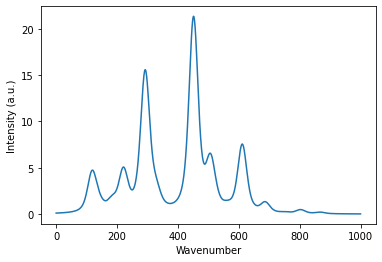

In [19]:
from crystal_out import crystalOut
import matplotlib.pyplot as plt
import numpy as np

def plot_spectra(output_file, sigma, gamma, wavenumber_range=(0,1000), resolution=1000):
    frequencies, convoluted_intensities = crystalOut(output_file).get_convoluted_spectra(sigma,gamma,wavenumber_range,resolution)
    plt.plot(frequencies, convoluted_intensities)
    axes = plt.gca()
    axes.set_xlabel("Wavenumber")
    axes.set_ylabel("Intensity (a.u.)")


plot_spectra("./crystal17_output_files/calc-Sb2O5_15_icsd1422_tzvp_PBE0/Sb2O5_15.out", 10, 10)

